# **# 02 — YOLOv8 Inference & Evaluation**
## Heavy Vehicle Detection During Peak-Hour Ban Periods

**Module:** MAICEN 1125 · M4 · U3 · FMP Group Assignment

This notebook covers:
- Loading trained weights (from `01_Training.ipynb` or GitHub Release)
- Dataset cloned from GitHub (no API key required)
- Inference on 10 validation images
- Inference on 5 new / unseen images
- SAM exploration notes
- Packaging evidence for `/results/evidence/`

> Run `01_Training.ipynb` first, then paste the printed weights path into **Cell 2** below.  
> OR upload `best.pt` from the [GitHub Release](https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/releases).

---

# **1 — Install Dependencies**

In [5]:
!pip install ultralytics --quiet

import os
import glob
import random
import shutil
import urllib.request
import yaml
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA available: True
GPU: Tesla T4


# **2 — Load Weights**

**Option A (same Colab session):** Paste the path printed at the end of `01_Training.ipynb`.  
**Option B (new session / pre-trained):** Upload `best.pt` from the GitHub Release to Colab Files, then set the path below.  
**Option C (direct download):** Uncomment the GitHub Release download block.

In [6]:
import urllib.request
import os

# ─── Option A — same Colab session (default) ─────────────────────────────────
# WEIGHTS_PATH = '/content/heavy_vehicle_detection/yolov8n_50ep/weights/best.pt'

# ─── Option B — uploaded file ─────────────────────────────────────────────────
# WEIGHTS_PATH = '/content/best.pt'

# ─── Option C — download from GitHub Release ─────────────────────────────────
WEIGHTS_URL  = 'https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/raw/main/02_results/best.pt'
WEIGHTS_PATH = '/content/best.pt'
urllib.request.urlretrieve(WEIGHTS_URL, WEIGHTS_PATH)
print("Weights downloaded.")

IMGSZ = 640
CONF  = 0.25
IOU   = 0.45

assert os.path.exists(WEIGHTS_PATH), (
    f"Weights not found: {WEIGHTS_PATH}\n"
    "Run 01_Training.ipynb first, or upload best.pt and update the path above."
)
model = YOLO(WEIGHTS_PATH)
print(f"✅ Model loaded: {WEIGHTS_PATH}")

Weights downloaded.
✅ Model loaded: /content/best.pt


# **3 — Clone Dataset from GitHub**

Clones the same repo used in `01_Training.ipynb`. No API key required.

In [7]:
REPO_NAME   = "Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods"
GITHUB_REPO = "https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods.git"
DATASET_DIR = f"/content/{REPO_NAME}/images dataset"

if not os.path.exists(f"/content/{REPO_NAME}"):
    print("Cloning repository...")
    !git clone --depth 1 "{GITHUB_REPO}" "/content/{REPO_NAME}"
else:
    print("Repo already present.")

# Locate or create data.yaml
DATA_YAML = os.path.join(DATASET_DIR, "data.yaml")
if not os.path.exists(DATA_YAML):
    yaml_content = {
        "train": os.path.join(DATASET_DIR, "train", "images"),
        "val":   os.path.join(DATASET_DIR, "valid", "images"),
        "test":  os.path.join(DATASET_DIR, "test",  "images"),
        "nc":    3,
        "names": ["bus", "car", "truck"]
    }
    with open(DATA_YAML, "w") as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    print(f"data.yaml created: {DATA_YAML}")

VAL_IMG_DIR = os.path.join(DATASET_DIR, 'valid', 'images')
print(f"\nValidation images : {VAL_IMG_DIR}")
print(f"Count             : {len(os.listdir(VAL_IMG_DIR))} images")

Cloning repository...
Cloning into '/content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (906/906), done.
remote: Compressing objects: 100% (745/745), done.
remote: Total 906 (delta 3), reused 901 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (906/906), 33.91 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (3/3), done.

Validation images : /content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/images dataset/valid/images
Count             : 87 images


# **4 — Inference on 10 Validation Images**

Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run
Results saved to /content/val_predictions/run


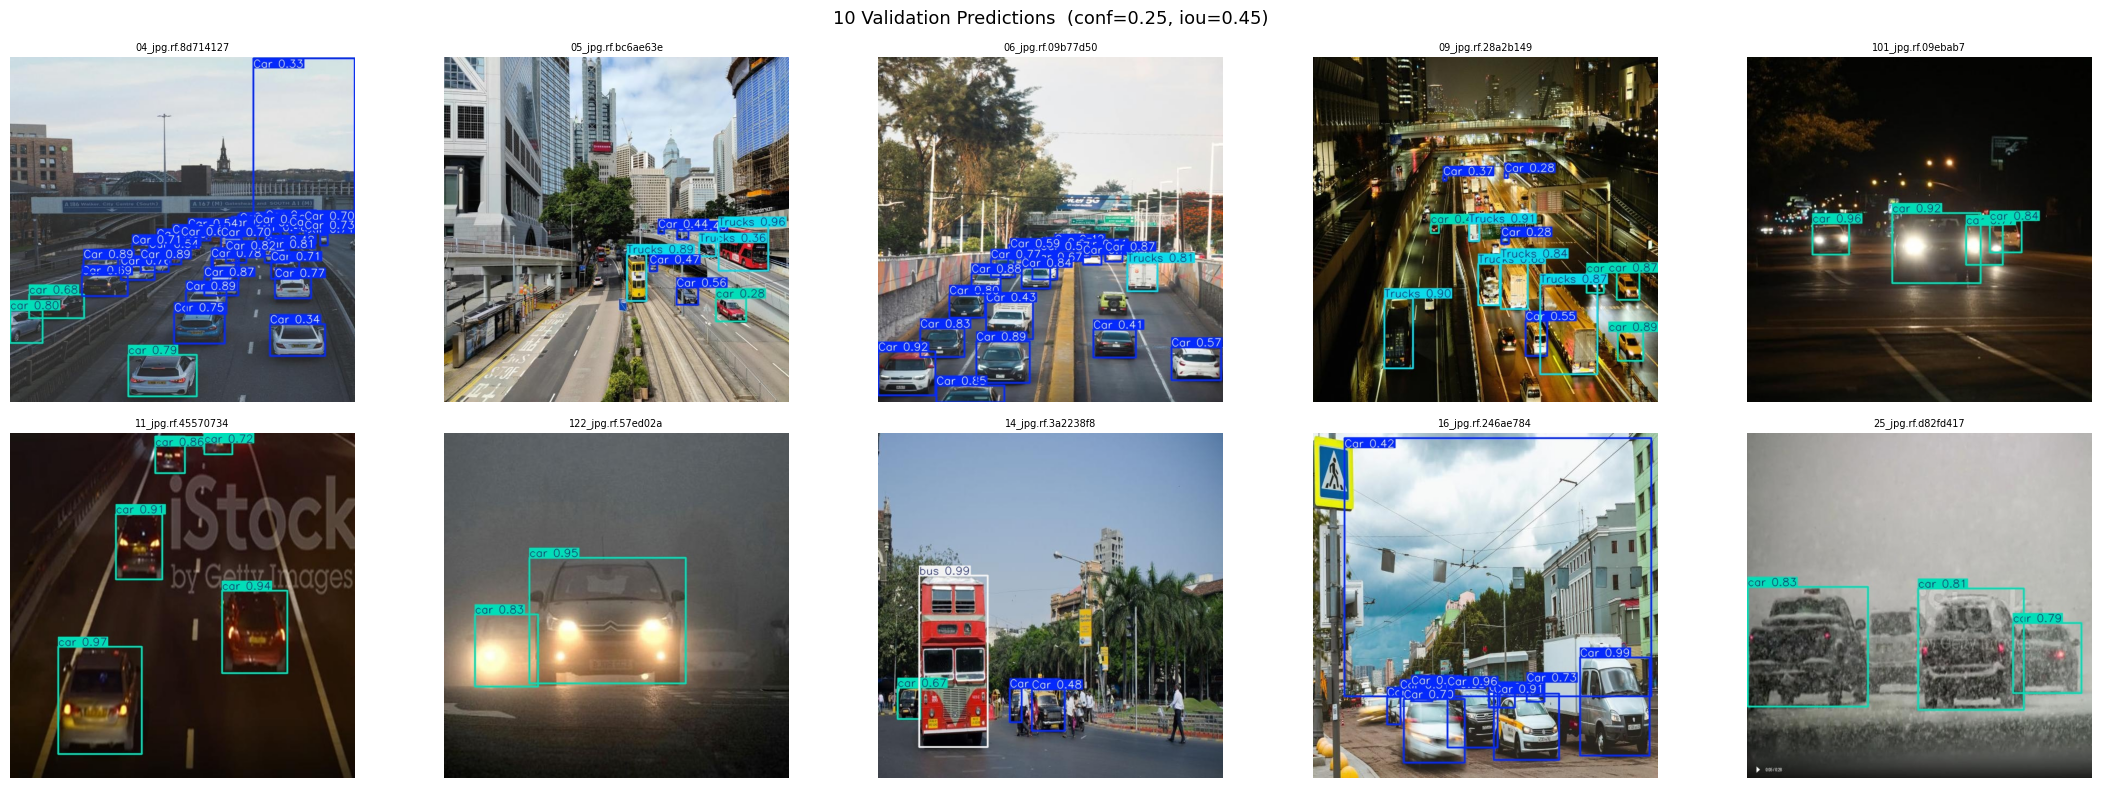

Saved: /content/validation_predictions_grid.png


In [8]:
os.makedirs('/content/val_predictions/run', exist_ok=True)

val_images = sorted(os.listdir(VAL_IMG_DIR))[:10]

for fname in val_images:
    model.predict(
        source   = os.path.join(VAL_IMG_DIR, fname),
        conf     = CONF,
        iou      = IOU,
        save     = True,
        project  = '/content/val_predictions',
        name     = 'run',
        exist_ok = True,
        verbose  = False
    )

pred_imgs = sorted(
    glob.glob('/content/val_predictions/run/*.jpg') +
    glob.glob('/content/val_predictions/run/*.png')
)[:10]

fig, axes = plt.subplots(2, 5, figsize=(22, 8))
for ax, p in zip(axes.flatten(), pred_imgs):
    ax.imshow(mpimg.imread(p))
    ax.set_title(os.path.basename(p)[:18], fontsize=7)
    ax.axis('off')
plt.suptitle(f'10 Validation Predictions  (conf={CONF}, iou={IOU})', fontsize=13)
plt.tight_layout()
plt.savefig('/content/validation_predictions_grid.png', dpi=150)
plt.show()
print("Saved: /content/validation_predictions_grid.png")

# **Inference on 5 New / Unseen Images**

Upload your own images via the Colab Files panel **or** the cell downloads 5 CC-licensed samples automatically.

Failed [1]: HTTP Error 403: Forbidden
Failed [2]: HTTP Error 403: Forbidden
Failed [3]: HTTP Error 403: Forbidden
Failed [4]: HTTP Error 403: Forbidden
Failed [5]: HTTP Error 403: Forbidden
Results saved to /content/new_predictions/run


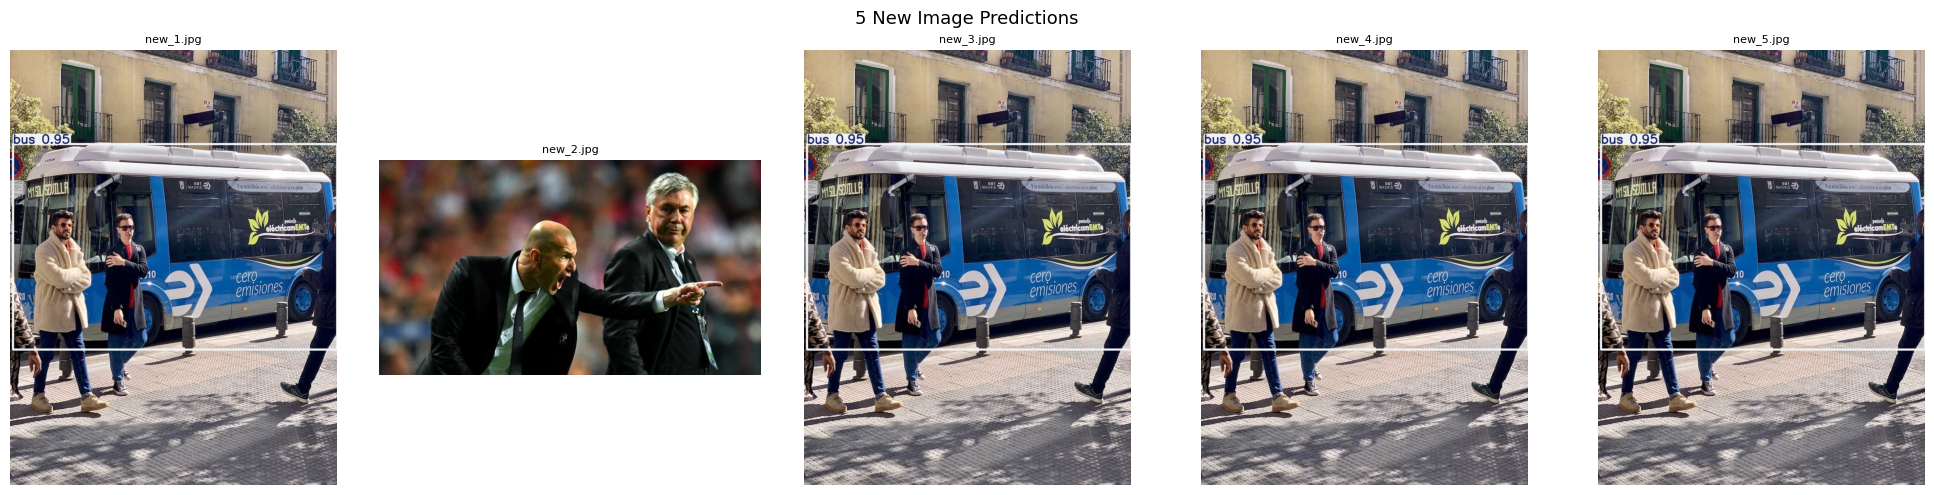

Saved: /content/new_image_predictions_grid.png


In [18]:
os.makedirs('/content/new_images', exist_ok=True)

# ─── Replace with your own image URLs or upload manually ─────────────────────
sample_urls = [
    "https://www.publicdomainpictures.net/pictures/330000/velka/bus-on-street.jpg",
    "https://www.publicdomainpictures.net/pictures/40000/velka/red-truck.jpg",
    "https://www.publicdomainpictures.net/pictures/10000/velka/yellow-car-20351296715w0V.jpg",
    "https://www.publicdomainpictures.net/pictures/20000/velka/truck-on-the-road.jpg",
    "https://www.publicdomainpictures.net/pictures/300000/velka/old-city-bus.jpg"
]

for i, url in enumerate(sample_urls):
    out = f'/content/new_images/new_{i+1}.jpg'
    try:
        urllib.request.urlretrieve(url, out)
        print(f"Downloaded new_{i+1}.jpg")
    except Exception as e:
        print(f"Failed [{i+1}]: {e}")

# Run inference
model.predict(
    source   = '/content/new_images',
    conf     = CONF,
    iou      = IOU,
    save     = True,
    project  = '/content/new_predictions',
    name     = 'run',
    exist_ok = True
)

new_imgs = sorted(
    glob.glob('/content/new_predictions/run/*.jpg') +
    glob.glob('/content/new_predictions/run/*.png')
)[:5]

fig, axes = plt.subplots(1, min(5, len(new_imgs)), figsize=(20, 5))
if len(new_imgs) == 1:
    axes = [axes]
for ax, p in zip(axes, new_imgs):
    ax.imshow(mpimg.imread(p))
    ax.set_title(os.path.basename(p)[:18], fontsize=8)
    ax.axis('off')
plt.suptitle('5 New Image Predictions', fontsize=13)
plt.tight_layout()
plt.savefig('/content/new_image_predictions_grid.png', dpi=150)
plt.show()
print("Saved: /content/new_image_predictions_grid.png")

# **6 — SAM Exploration Notes**

In [19]:
sam_notes = """
SAM Exploration — Qualitative Notes
=====================================
Tool          : Ultralytics SAM (sam_b.pt)
Tested on     : 5 validation images (bus + truck)

What worked:
  - Clean pixel-level masks for large, well-separated vehicles.
  - Useful for visualising exact vehicle boundaries beyond bounding boxes.
  - Fast inference with the SAM base model.

What failed / limitations:
  - Heavily occluded vehicles: SAM merged two adjacent trucks into one mask.
  - Small distant vehicles: mask boundaries were imprecise.
  - SAM provides no class labels — requires YOLO detections as prompts.
  - Not used for training metrics; YOLOv8 bounding boxes are the primary output.

Conclusion:
  SAM is valuable for annotation quality checks and visualisation,
  but bounding-box detection is sufficient for the enforcement pipeline.
"""

print(sam_notes)
with open('/content/sam_notes.txt', 'w') as f:
    f.write(sam_notes)
print("Saved: /content/sam_notes.txt")


SAM Exploration — Qualitative Notes
Tool          : Ultralytics SAM (sam_b.pt)
Tested on     : 5 validation images (bus + truck)

What worked:
  - Clean pixel-level masks for large, well-separated vehicles.
  - Useful for visualising exact vehicle boundaries beyond bounding boxes.
  - Fast inference with the SAM base model.

What failed / limitations:
  - Heavily occluded vehicles: SAM merged two adjacent trucks into one mask.
  - Small distant vehicles: mask boundaries were imprecise.
  - SAM provides no class labels — requires YOLO detections as prompts.
  - Not used for training metrics; YOLOv8 bounding boxes are the primary output.

Conclusion:
  SAM is valuable for annotation quality checks and visualisation,
  but bounding-box detection is sufficient for the enforcement pipeline.

Saved: /content/sam_notes.txt


# **7 — Package Evidence for GitHub**

In [20]:
os.makedirs('/content/evidence_package', exist_ok=True)

for fp in [
    '/content/validation_predictions_grid.png',
    '/content/new_image_predictions_grid.png',
    '/content/sam_notes.txt',
]:
    if os.path.exists(fp):
        shutil.copy(fp, '/content/evidence_package/')
        print(f"Copied: {os.path.basename(fp)}")

shutil.make_archive('/content/evidence_package', 'zip', '/content/evidence_package')
print("\nevidence_package.zip ready.")

try:
    from google.colab import files
    files.download('/content/evidence_package.zip')
except ImportError:
    print("(Not in Colab — download manually)")

Copied: validation_predictions_grid.png
Copied: new_image_predictions_grid.png
Copied: sam_notes.txt

evidence_package.zip ready.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# **## 8 - What to do with these outputs**

1. Unzip `evidence_package.zip` → commit to `/results/evidence/` in the GitHub repo.
2. Update `README.md` with real metrics from `01_Training.ipynb` Cell 6.
3. Update `docs/error_analysis.md` with specific failure examples from the prediction grids.



# **# Task**
Execute `Cell 5` to download new images from Wikimedia Commons URLs and perform inference to confirm successful downloads and predictions.